In [49]:
import pandas as pd
import sys
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from typing import List, Optional
from selenium import webdriver
from supabase import create_client, Client
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
from mplsoccer import Pitch, FontManager, Sbopen
import urllib
from PIL import Image
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
import networkx as nx

In [354]:
import requests

# URL of DejaVu Sans font from GitHub
url = "https://github.com/prawnpdf/prawn/raw/master/data/fonts/DejaVuSans.ttf"
font_path = "DejaVuSans.ttf"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(font_path, "wb") as f:
        f.write(response.content)
    print("Font downloaded successfully.")
else:
    print("Failed to download the font.")


Font downloaded successfully.


In [95]:
whoscored_url = 'https://www.whoscored.com/matches/1811539/live/south-america-copa-libertadores-2024-universitario-de-deportes-junior-fc'

In [5]:
def scraping_whoscored(whoscored_url):

    ''' Explanation...'''

    # Setting up the driver
    driver = webdriver.Chrome()

    # Set up the Driver for the URL
    driver.get(whoscored_url)

    # Creating the soup element. We will get the HTML code of the page
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Selecting the block of code we are interested in, where the JSON data lies
    # Right click -> View Source Code -> Look for the MatchCentreData
    element = soup.select_one('script:-soup-contains("matchCentreData")')

    # Extracting the dictionary of events data.
    # There is a primary key 'id' and an eventId associated with each record
    # Coming in JSON format, preferred by web/app developers
    matchdict = json.loads(element.text.split("matchCentreData: ")[1].split(',\n')[0])

    # --------------- Data Cleaning -----------------------

    # Filtering using variable definition for only storing events dictionary data
    match_events = matchdict['events']

    # Converting JSON data into a pandas dataframe
    df = pd.DataFrame(match_events)

    # Dropping all rows that do not include a player ID
    df.dropna(subset='playerId', inplace=True)

    # Replacing all NaN values to None
    df = df.where(pd.notnull(df), None)

    # Renaming columns to ensure consistency and data integrity
    df = df.rename(
        {
            'eventId': 'event_id',
            'expandedMinute': 'expanded_minute',
            'outcomeType': 'outcome_type',
            'isTouch': 'is_touch',
            'playerId': 'player_id',
            'teamId': 'team_id',
            'endX': 'end_x',
            'endY': 'end_y',
            'blockedX': 'blocked_x',
            'blockedY': 'blocked_y',
            'goalMouthZ': 'goal_mouth_z',
            'goalMouthY': 'goal_mouth_y',
            'isShot': 'is_shot',
            'cardType': 'card_type',
            'isGoal': 'is_goal'
        },
        axis=1
    )

    # Working til here

    # Creating new columns from the dictionaries within the dataset variables (df['period', 'type'], etc)
    df['period_display_name'] = df['period'].apply(lambda x: x['displayName'])  # The displayname variable is a key within the dictionary within the dataset (json)
    df['type_display_name'] = df['type'].apply(lambda x: x['displayName'])
    df['outcome_type_display_name'] = df['outcome_type'].apply(lambda x: x['displayName'])

    # Creating a column of 'is_goal' for games without goals. 
    # Otherwise it will create errors
    if 'is_goal' not in df.columns:
        print('missing goals')
        df['is_goal'] = False
        
    # Fixing for offside given
    # Dropping rows that have the offisde given
    df = df[~(df['type_display_name'] == "OffsideGiven")]

    # Dropping the initial dictionary columns since we don't need them anymore
    df.drop(columns = ['period', 'type', 'outcome_type'], inplace=True)

    # Defining and keeping only desired columns
    # ~~ Watch out here. Some leagues will have different columns
    df = df[[ 
        'id', 'event_id', 'minute', 'second', 'team_id', 'player_id', 'x','y', 'end_x', 'end_y', 
        'qualifiers', 'is_touch', 'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'is_goal', 'type_display_name', 'outcome_type_display_name',
        'period_display_name'
    ]]

    # -- Variables not used: , 'card_type'

    # Defining the types of each variable
    df[['id', 'event_id', 'minute', 'team_id', 'player_id']] = df[['id', 'event_id', 'minute', 'team_id', 'player_id']].astype(int) 
    df[['second', 'x', 'y', 'end_x', 'end_y']] = df[['second', 'x', 'y', 'end_x', 'end_y']].astype(float)
    df[['is_shot', 'is_goal']] =df[['is_shot', 'is_goal']].astype(bool)

    df['is_goal'] = df['is_goal'].fillna(False)
    df['is_shot'] = df['is_shot'].fillna(False)

    # -- Variables not used: , 'card_type'

    # Loop for ensuring accuracy of the columns
    # Pandas & Numpy treat the NaN differently, this will help to assign as None all of those values that previously didn't change from NaN to None
    for column in df.columns:
        if df[column].dtype == np.float64 or df[column].dtype == np.float32:
            df[column] = np.where(
                np.isnan(df[column]),
                None,
                df[column]
            )

    # --------------- Appending Player Data -----------------------

    # Create a new variable to store the new coming information
    # We then later will merge it with initial database
    team_info = []

    # Appending player information of Home team
    team_info.append({
        'team_id': matchdict['home']['teamId'],
        'name': matchdict['home']['name'],
        'country_name': matchdict['home']['countryName'],
        'manager_name': matchdict['home']['managerName'],
        'players': matchdict['home']['players'],
    })

    # Appending player information of Away team
    team_info.append({
        'team_id': matchdict['away']['teamId'],
        'name': matchdict['away']['name'],
        'country_name': matchdict['away']['countryName'],
        'manager_name': matchdict['away']['managerName'],
        'players': matchdict['away']['players'],
    })


    # Creating function for storing player information into new list
    def insert_players(team_info):
        players = []
        
        for team in team_info:
            for player in team['players']:
                players.append({
                    'player_id': player['playerId'],
                    'team_id': team['team_id'],
                    'shirt_no': player['shirtNo'],
                    'name': player['name'],
                    'position': player['position'],
                    'age': player['age'],
                    'MOTM': player['isManOfTheMatch'] # Might not have in Libertadores (Doble check later)
                })
        return players
    
    # Creating function for storing team information and name
    def insert_team(team_info):
        teams = []
        for team in team_info:
            teams.append({
            'team_id': team['team_id'],
            'team': team['name']
            })
        return teams

    # Applying functions
    players = insert_players(team_info)
    teams = insert_team(team_info)

    # Converting JSON data into a pandas dataframe
    players_df = pd.DataFrame(players)
    teams_df = pd.DataFrame(teams)

     # --------------- Merging Events Data with Player Data -----------------------

     # We are going to do the merge on player_id.
    # SQL Schema -> primary key in Players table and foreign key in events
    players_df = pd.merge(players_df, teams_df, on='team_id')
    final_df = pd.merge(df, players_df, on='player_id')

    # Sorting the df in ascending for minute and second
    final_df = final_df.sort_values(by=['minute', 'second'], ascending=True)

    # Resetting the index if needed
    final_df = final_df.reset_index(drop=True)

    # Setting up the name for the file
    # Finding all positions of '-'
    # positions = [pos for pos, char in enumerate(whoscored_url) if char == '-']

    # Getting the position of the second to last '-'
    # second_to_last_dash_position = positions[-2]

    # Slicing the string from the second to last '-' to the end
    # new_variable = whoscored_url[second_to_last_dash_position + 1:]

    # Saving the file for later in CSV
    # final_df.to_csv(f'Datasets/{new_variable}.csv', index=False)

    return final_df

df = scraping_whoscored(whoscored_url)

In [7]:
df.head()

,id,event_id,minute,second,team_id_x,player_id,x,y,end_x,end_y,...,type_display_name,outcome_type_display_name,period_display_name,team_id_y,shirt_no,name,position,age,MOTM,team
0,2684305553,3,0,0.0,2050,445146,49.7,50.1,51.0,48.1,...,Pass,Successful,FirstHalf,2050,17,Jairo Concha,MC,25,False,Universitario de Deportes
1,2684305555,4,0,2.0,2050,445809,49.1,44.2,51.9,13.5,...,Pass,Successful,FirstHalf,2050,18,Rodrigo Ureña,DMC,32,False,Universitario de Deportes
2,2684305557,5,0,3.0,2050,149542,61.0,4.1,69.8,26.6,...,Pass,Successful,FirstHalf,2050,24,Andy Polo,MR,30,False,Universitario de Deportes
3,2684319789,404,0,5.0,2050,417919,73.5,28.0,62.9,27.5,...,Pass,Successful,FirstHalf,2050,20,Álex Valera,FW,28,False,Universitario de Deportes
4,2684305573,6,0,10.0,2050,445809,57.7,36.6,59.1,89.1,...,Pass,Successful,FirstHalf,2050,18,Rodrigo Ureña,DMC,32,False,Universitario de Deportes


In [22]:
colors_alianza = ['#192745', '#4B2583', '#b29400', '#d1d3d4'] # https://issuu.com/vistaprevia/docs/manual_de_identidad_de_marca_-_al

colors_universitario = ['#FFFEF4', '#A6192E', '#000000', '#C6AA76', '#A7A8A9'] # https://universitario.pe/media/download/prensa/ID_Manual_Universitario_2020.pdf

colors_sporting_cristal = ['#E20A17', '#3ABFF0', '#FCDB18'] # FONDO BLANCO # https://issuu.com/andrebendezu777/docs/manual_identidad_sc_bendezu_andre

,index,id,event_id,minute,second,team_id_x,player_id,x,y,end_x,...,period_display_name,team_id_y,shirt_no,name,position,age,MOTM,team,passer,receiver
0,0,2684305553,3,0,0.0,2050,445146,49.7,50.1,51.0,...,FirstHalf,2050,17,Jairo Concha,MC,25,False,Universitario de Deportes,Jairo Concha,Rodrigo Ureña
1,1,2684305555,4,0,2.0,2050,445809,49.1,44.2,51.9,...,FirstHalf,2050,18,Rodrigo Ureña,DMC,32,False,Universitario de Deportes,Rodrigo Ureña,Andy Polo
2,2,2684305557,5,0,3.0,2050,149542,61.0,4.1,69.8,...,FirstHalf,2050,24,Andy Polo,MR,30,False,Universitario de Deportes,Andy Polo,Álex Valera
3,3,2684319789,404,0,5.0,2050,417919,73.5,28.0,62.9,...,FirstHalf,2050,20,Álex Valera,FW,28,False,Universitario de Deportes,Álex Valera,Rodrigo Ureña
4,4,2684305573,6,0,10.0,2050,445809,57.7,36.6,59.1,...,FirstHalf,2050,18,Rodrigo Ureña,DMC,32,False,Universitario de Deportes,Rodrigo Ureña,Segundo Portocarrero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,976,2684323827,555,64,52.0,2050,417919,55.3,24.5,50.9,...,SecondHalf,2050,20,Álex Valera,FW,28,False,Universitario de Deportes,Álex Valera,Jairo Concha
496,977,2684323833,556,64,56.0,2050,445146,44.7,48.4,41.9,...,SecondHalf,2050,17,Jairo Concha,MC,25,False,Universitario de Deportes,Jairo Concha,Aldo Corzo
497,978,2684323849,557,64,57.0,2050,62465,41.9,24.1,54.7,...,SecondHalf,2050,29,Aldo Corzo,DC,35,False,Universitario de Deportes,Aldo Corzo,Martín Pérez Guedes
498,979,2684323857,558,65,1.0,2050,125555,60.7,6.4,64.1,...,SecondHalf,2050,16,Martín Pérez Guedes,MC,33,False,Universitario de Deportes,Martín Pérez Guedes,Jairo Concha


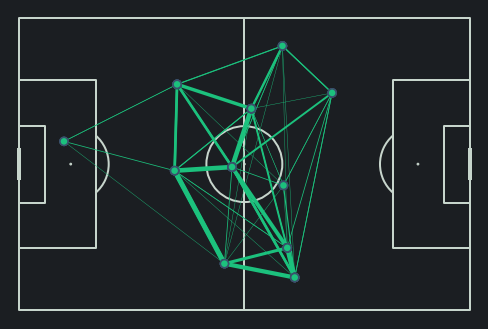

In [273]:
def get_team_interest():

    list_of_teams = ['Universitario de Deportes']
    # Maybe try to assign colors here as well
    
    return list_of_teams


color_home = '#1CC17D'
color_away = '#CE2939'

# Pass Network
def pass_network(df, marker_color):
    
    # Filter to keep only records that correspond to team of interest
    df = df[df['team'].isin(get_team_interest())]
    
    # Creating dataframe only of substitution records
    subs = df[df['type_display_name'] == 'SubstitutionOff']
    # Only keeping the minute variable of this new sub df
    subs = subs['minute']
    first_sub = subs.min()
    
    # Keeping the data only with records before first substitution
    df = df[df['minute'] < first_sub].reset_index()
    
    # Creating new variables
    df['passer'] = df['name']
    df['receiver'] = df['name'].shift(-1)
    
    # Only interested in successful passes
    df = df[df['type_display_name'] == 'Pass']
    df = df[df['outcome_type_display_name'] == 'Successful']
    
    # Calculating Average Locations of Players
    avg_locations = df.groupby('passer').agg({'x':['mean'], 'y':['mean', 'count']})
    avg_locations.columns = ['x', 'y', 'count']
    avg_locations
    
    # Passes between players (Count of Associations)
    pass_between = df.groupby(['passer', 'receiver']).id.count().reset_index()
    pass_between.rename({'id':'pass_count'}, axis='columns', inplace=True)
    
    # Merging DataFrames
    pass_between = pass_between.merge(avg_locations, left_on='passer',right_index=True)
    pass_between = pass_between.merge(avg_locations, left_on='receiver',right_index=True,suffixes=['','_end'])
    
    
    ################## Pitch Generation Section ##################
    
    # Setting the text color (labels and texts)
    rcParams['text.color'] = '#c7d5cc'
    
    # Setting parameters for Plotting
    max_line_width = 5
    max_marker_size = 65
    szobo_marker_size = 15

    # Adjusting marker size based on the passer (Szoboslai)
    pass_between['marker_size'] = pass_between.apply(lambda row: szobo_marker_size if row['passer'] == 'Dominik Szoboszlai' else max_marker_size, axis=1)
    pass_between['marker_color'] = pass_between.apply(lambda row: '#21FF77' if row['passer'] == 'Dominik Szoboszlai' else marker_color, axis=1)

    # Setting up the width of the pass lines
    pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() * max_line_width)

    # Setting color for pass connections involving Szoboslai
    # Setting up a Player B just in case for future modifications
    pass_between['line_color'] = pass_between.apply(lambda row: '#1CC17D' if row['passer'] == 'Dominik Szoboszlai' or row['passer'] == 'Player B' else marker_color, axis=1)

    rcParams['text.color'] = '#c7d5cc'
    
    # Plotting
    pitch = Pitch(pitch_type='opta', pitch_color='#1B1E22', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(8.5, 6.5), constrained_layout=True, tight_layout=False) # (8.5, 8.5
    fig.set_facecolor("#1B1E22")
    
    # Drawing the pass lines (links/edges)
    pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color=pass_between.line_color, zorder=1, ax=ax)

    # Drawing the nodes (players)
    nodes = pitch.scatter(pass_between.x, pass_between.y, s=pass_between.marker_size,
                      color=pass_between.marker_color, edgecolors='#3a506b', linewidth=1.5, alpha=1, zorder=1, ax=ax)

    # Labeling the nodes with player name
    #for i, txt in enumerate(pass_between['passer']):
     #   ax.annotate(txt, (pass_between.x.iloc[i], pass_between.y.iloc[i]), color='#A3D3D3', fontsize=5, ha='center', va='bottom',xytext=(0, 12), textcoords='offset points')

    # Setting the title
    #ax_title = ax.set_title(f'Pass Network', fontsize=15) #, color='white')
    
    fig.savefig('pass_network.png', dpi=100, bbox_inches='tight') #dpi=300
    # Adding the image
    #image_path = f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Team_Logos/{team}.png'
    #team_logo = Image.open(image_path)

    # Define the position and size of the image (left, bottom, width, height)
    #photo_ax = fig.add_axes([0.42, 0.88, 0.2, 0.2])  # Adjust the coordinates and size as needed
    #photo_ax.set_facecolor("#22312b")

    #photo_ax.imshow(team_logo)
    #photo_ax.axis('off')
    
    return df

pass_network(df, color_home)
    



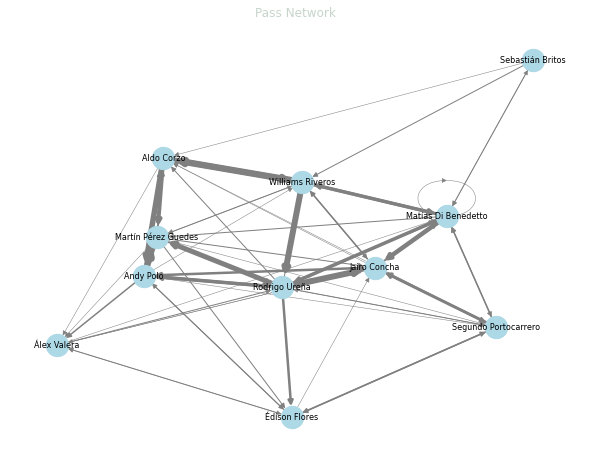

,name,Degree Centrality,Betweenness Centrality,Clustering Coefficient,Triangles
0,Jairo Concha,1.5,0.09,0.78,28
1,Rodrigo Ureña,1.5,0.02,0.78,28
5,Matías Di Benedetto,1.4,0.20,0.62,13
2,Andy Polo,1.3,0.03,0.82,23
8,Martín Pérez Guedes,1.3,0.09,0.78,28
6,Williams Riveros,1.2,0.04,0.71,15
4,Segundo Portocarrero,1.1,0.09,0.81,17
7,Aldo Corzo,1.1,0.19,0.68,19
3,Álex Valera,0.9,0.45,0.81,17
10,Édison Flores,0.9,0.10,0.93,14


In [331]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def get_team_interest():
    return ['Universitario de Deportes']

def pass_network_networkx(df):
    # Filter to keep only records that correspond to team of interest
    df = df[df['team'].isin(get_team_interest())]

    # Creating dataframe only of substitution records
    subs = df[df['type_display_name'] == 'SubstitutionOff']
    subs = subs['minute']
    first_sub = subs.min()

    # Keeping data before first substitution
    df = df[df['minute'] < first_sub].reset_index()

    # Creating new variables
    df['passer'] = df['name']
    df['receiver'] = df['name'].shift(-1)

    # Only successful passes
    df = df[df['type_display_name'] == 'Pass']
    df = df[df['outcome_type_display_name'] == 'Successful']

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges (passes) to the graph with weights
    for _, row in df.iterrows():
        passer = row['passer']
        receiver = row['receiver']
        if G.has_edge(passer, receiver):
            G[passer][receiver]['weight'] += 1
        else:
            G.add_edge(passer, receiver, weight=1)

    # Compute network metrics
    degree_centrality = nx.degree_centrality(G)  # How connected a player is
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')  # How often a player is in shortest paths
    clustering_coeff = nx.clustering(G.to_undirected())  # How well players form triangles
    triangles = nx.triangles(G.to_undirected())  # Number of triangles each player is involved in

    # Store results in a DataFrame
    metrics_df = pd.DataFrame({
        'name': list(G.nodes),
        'Degree Centrality': [degree_centrality[p] for p in G.nodes],
        'Betweenness Centrality': [betweenness_centrality[p] for p in G.nodes],
        'Clustering Coefficient': [clustering_coeff[p] for p in G.nodes],
        'Triangles': [triangles[p] for p in G.nodes]
    }).sort_values(by='Degree Centrality', ascending=False)

    # Plot the network
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Positioning of nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray", font_size=8, width=[d['weight'] / 2 for (_, _, d) in G.edges(data=True)])
    
    plt.title("Pass Network")
    plt.show()

    return metrics_df

# Example call
pass_metrics = pass_network_networkx(df)

pass_metrics[['Betweenness Centrality', 'Clustering Coefficient']] = pass_metrics[['Betweenness Centrality', 'Clustering Coefficient']].round(2) 
pass_metrics


In [25]:
def xT_grid(df):
    
    # Keeping only specific Team records
    df = df.loc[(df['team'].isin(get_team_interest())) & (df['type_display_name']=='Pass') & (df['outcome_type_display_name']=='Successful')]
    df.reset_index(inplace=True)
    
    # xT Grid
    xT = np.array([
        [0.006383, 0.007796, 0.008449, 0.009777, 0.011263, 0.012483, 0.014736, 0.017451, 0.021221, 0.027563, 0.034851, 0.037926],
        [0.007501, 0.008786, 0.009424, 0.010595, 0.012147, 0.013845, 0.016118, 0.018703, 0.024015, 0.029533, 0.040670, 0.046477],
        [0.008880, 0.009777, 0.010013, 0.011105, 0.012692, 0.014291, 0.016856, 0.019351, 0.024122, 0.028552, 0.054911, 0.064426],
        [0.009411, 0.010827, 0.010165, 0.011324, 0.012626, 0.014846, 0.016895, 0.019971, 0.023851, 0.035113, 0.108051, 0.257454],
        [0.009411, 0.010827, 0.010165, 0.011324, 0.012626, 0.014846, 0.016895, 0.019971, 0.023851, 0.035113, 0.108051, 0.257454],
        [0.008880, 0.009777, 0.010013, 0.011105, 0.012692, 0.014291, 0.016856, 0.019351, 0.024122, 0.028552, 0.054911, 0.064426],
        [0.007501, 0.008786, 0.009424, 0.010595, 0.012147, 0.013845, 0.016118, 0.018703, 0.024015, 0.029533, 0.040670, 0.046477],
        [0.006383, 0.007796, 0.008449, 0.009777, 0.011263, 0.012483, 0.014736, 0.017451, 0.021221, 0.027563, 0.034851, 0.037926]
    ])

    xT_rows, xT_cols = xT.shape
    
    # Categorizing each record in a bin for starting point and ending point
    df['x1_bin'] = pd.cut(df['x'], bins = xT_cols, labels=False)
    df['y1_bin'] = pd.cut(df['y'], bins = xT_rows, labels=False)

    df['x2_bin'] = pd.cut(df['end_x'], bins = xT_cols, labels=False)
    df['y2_bin'] = pd.cut(df['end_y'], bins = xT_rows, labels=False)
    
    # Defining start zone and end zone values of passes (kinda like x,y coordinates in a map plot)
    df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)
    df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)

    # The difference of end_zone and start_zone is the expected threat value for the action (pass) - not accounting for dribble xT here
    # Value can be negative or positive (progressive)
    df['Pass xT'] = df['end_zone_value'] - df['start_zone_value']
    # Progressive xT measures progressive passes
    df['Progressive xT'] = ''
    
    # Iterating and filling values for Progressive xT
    counter = 0 

    while counter < len(df):
        if df['Pass xT'][counter] > 0:
            df['Progressive xT'][counter] = df['Pass xT'][counter]
        else:
            df['Progressive xT'][counter] = 0.00
        counter += 1
        
    return df

xt_df = xT_grid(df)

        
    
xt_df.head()    

/var/folders/7x/mwsg2nfd0gsf5h73ty0mnrb80000gn/T/ipykernel_28027/3328147611.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x1_bin'] = pd.cut(df['x'], bins = xT_cols, labels=False)
/var/folders/7x/mwsg2nfd0gsf5h73ty0mnrb80000gn/T/ipykernel_28027/3328147611.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y1_bin'] = pd.cut(df['y'], bins = xT_rows, labels=False)
/var/folders/7x/mwsg2nfd0gsf5h73ty0mnrb80000gn/T/ipykernel_28027/3328147611.py:25: SettingWithCopyWarning: 
A value is trying to be 

,index,id,event_id,minute,second,team_id_x,player_id,x,y,end_x,...,MOTM,team,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,Pass xT,Progressive xT
0,0,2684305553,3,0,0.0,2050,445146,49.7,50.1,51.0,...,False,Universitario de Deportes,5,4,5,3,0.014846,0.014846,0.000000,0.0
1,1,2684305555,4,0,2.0,2050,445809,49.1,44.2,51.9,...,False,Universitario de Deportes,5,3,6,1,0.014846,0.016118,0.001272,0.001272
2,2,2684305557,5,0,3.0,2050,149542,61.0,4.1,69.8,...,False,Universitario de Deportes,7,0,8,2,0.017451,0.024122,0.006671,0.006671
3,3,2684319789,404,0,5.0,2050,417919,73.5,28.0,62.9,...,False,Universitario de Deportes,8,2,7,2,0.024122,0.019351,-0.004771,0.0
4,4,2684305573,6,0,10.0,2050,445809,57.7,36.6,59.1,...,False,Universitario de Deportes,6,2,7,7,0.016856,0.017451,0.000595,0.000595


In [293]:
# xT Chart
xT_gb = xt_df.groupby(by='name', as_index=False).agg({'Pass xT': 'sum', 'Progressive xT': 'sum'}).sort_values(by='Progressive xT', ascending=False).reset_index(drop=True)
 
xT_gb[['Pass xT', 'Progressive xT']] = xT_gb[['Pass xT', 'Progressive xT']].astype(float).round(2)

#xT_gb.sort_values(by='Progressi
xT_gb[['Pass xT', 'Progressive xT']] = xT_gb[['Pass xT', 'Progressive xT']].round(2) 

xT_gb

,name,Pass xT,Progressive xT
0,Andy Polo,0.13,0.19
1,Rodrigo Ureña,0.15,0.17
2,Martín Pérez Guedes,0.11,0.14
3,Aldo Corzo,0.11,0.13
4,Matías Di Benedetto,0.05,0.06
5,Williams Riveros,0.03,0.05
6,Segundo Portocarrero,0.01,0.04
7,Jairo Concha,-0.01,0.03
8,Édison Flores,0.02,0.03
9,Jorge Murrugarra,0.01,0.02


In [68]:
# passes Actions in general
passes_df = df[(df['type_display_name'] == 'Pass') & df['team'].isin(get_team_interest())]

passes_gp = passes_df.groupby(by='name', as_index=False).agg({'type_display_name':'count'}).sort_values(by='type_display_name', ascending=False).reset_index(drop=True)

succ_pass_df = passes_df[passes_df['outcome_type_display_name'] == 'Successful']
succ_passes_gp = succ_pass_df.groupby(by='name', as_index=False).agg({'type_display_name':'count'}).sort_values(by='type_display_name', ascending=False).reset_index(drop=True)

merged_passes = pd.merge(passes_gp, succ_passes_gp, how='inner', on='name')

merged_passes.rename(columns={'type_display_name_x' : 'Total Passes' , 'type_display_name_y': 'Successful Passes'}, inplace=True)

merged_passes['Succ (%)'] = round(merged_passes['Successful Passes'] / merged_passes['Total Passes'] * 100,2)


# merged_passes['Succ (%)'] = merged_passes['Succ (%)'].apply(lambda x: f"{x:.1f}%")

# Keeping only record with more than 10 passes
merged_passes = merged_passes[merged_passes['Total Passes'] >= 10]

merged_passes

,name,Total Passes,Successful Passes,Succ (%)
0,Rodrigo Ureña,68,56,82.35
1,Matías Di Benedetto,64,48,75.00
2,Williams Riveros,64,56,87.50
3,Aldo Corzo,59,45,76.27
4,Andy Polo,51,42,82.35
5,Martín Pérez Guedes,38,25,65.79
6,Jairo Concha,33,24,72.73
7,Segundo Portocarrero,25,17,68.00
8,Édison Flores,16,8,50.00
9,Sebastián Britos,15,12,80.00


In [332]:
# quick mapping
merged_passes['name'].unique()

mapping = {
    
    'Rodrigo Ureña':'R. Ureña', 
    'Matías Di Benedetto':'Di Benedetto', 
    'Williams Riveros':'William Riveros',
    'Aldo Corzo': 'Aldo Corzo', 
    'Andy Polo':'Andy Polo' , 
    'Martín Pérez Guedes': 'Perez Guedes', 
    'Jairo Concha': 'J. Concha',
    #'Segundo Portocarrero', 
    'Édison Flores':'E. Flores', 
    'Sebastián Britos': 'S. Britos',
    'Jorge Murrugarra': 'Murrugarra', 
    'Álex Valera':'A. Valera'
    
}

# Quick mapping to rename players
merged_passes['name'] = merged_passes['name'].replace(mapping)
xT_gb['name'] = xT_gb['name'].replace(mapping) 
pass_metrics['name'] = pass_metrics['name'].replace(mapping)

### Beautiful Table - Passes

,badge,name,Total Passes,Successful Passes,Succ (%)
index,,,,,
1,players_png/William Riveros.png,William Riveros,64,56,87.50
2,players_png/R. Ureña.png,R. Ureña,68,56,82.35
3,players_png/Andy Polo.png,Andy Polo,51,42,82.35


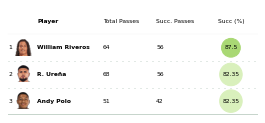

In [284]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import circled_image # image
from plottable.plots import image

# Beautiful Tables

def beautiful_table_pass(df):
    
    overall = df 
    df = df.sort_values(by='Succ (%)', ascending=False)
    
    df = df.head(3)
    # Reset the index (to avoid any existing index) and then add 1 to the index values
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    
    # Read in the logos
    df['badge'] = df['name'].apply(
        lambda x: f"players_png/{x}.png"
    )
    
    #define color map
    cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
    )
    
    df = df[['badge', 'name', 'Total Passes', 'Successful Passes', 'Succ (%)']]
    
    col_defs = (
        
        [
            ColumnDefinition(
                name='name',
                title='Player',
                textprops={"ha": "left", "weight": "bold", 'color':'black'},
                width=2.5,
                
            ),
            
            ColumnDefinition(
                name='index',
                title="",
                textprops={"ha": "left", 'color':'black'},
                width=0.25,
            ),
            
            ColumnDefinition(
                name='Total Passes',
                textprops={"ha": "left", 'color':'black'},
                width=2,
            ),
            
            ColumnDefinition(
                name='Successful Passes',
                title='Succ. Passes',
                textprops={"ha": "left", 'color':'black'},
                width=2,
            ),
            

            
            ColumnDefinition(
                name="Succ (%)",
                width=2,
                textprops={
                    "ha":"center",
                    "bbox": {"boxstyle": "circle", "pad": 0.45},
                    'color':'black',
                },
                cmap=normed_cmap(overall["Succ (%)"], cmap=matplotlib.cm.PiYG, num_stds=2.5),
            ),
            
            ColumnDefinition(
                name="badge",
                title="",
                textprops={"ha": "center", "va": "center"}, #, 'color': bg_color},
                width=0.6,
                plot_fn=image,
            )
        ]
        
        
    )
    
    # Graph
    plt.rcParams["font.family"] = ["DejaVu Sans"]
    plt.rcParams["savefig.bbox"] = "tight"
    
    fig, ax = plt.subplots(figsize=(4.5, 2))
    
    # **Set Background Color**
    #bg_color = "red"  # Change this to any color you want
    #fig.patch.set_facecolor(bg_color)
    #ax.set_facecolor(bg_color)
    
    table = Table(
        df,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 6},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 0.1, "linestyle": "-"},
        column_border_kw={"linewidth": 0.4, "linestyle": "-"},
    )#.autoset_fontcolors(colnames=["xG", "xGA","xPTS", "xG per Game", "xGA per Game"])
    fig.savefig(f"table_passes.png", facecolor=ax.get_facecolor(), dpi=200)
    
    return df

beautiful_table_pass(merged_passes)
    

### Beautiful Table - xT

/var/folders/7x/mwsg2nfd0gsf5h73ty0mnrb80000gn/T/ipykernel_28027/2283840770.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['badge'] = df['name'].apply(


,badge,name,Progressive xT
index,,,
1,players_png/Andy Polo.png,Andy Polo,0.19
2,players_png/R. Ureña.png,R. Ureña,0.17
3,players_png/Perez Guedes.png,Perez Guedes,0.14


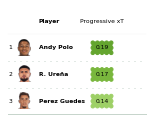

In [341]:
def beautiful_table_xT(df):
    
    overall = df 
    # df = df.sort_values(by='', ascending=False)
    
    df = df.head(3)
    # Reset the index (to avoid any existing index) and then add 1 to the index values
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    
    # Read in the logos
    df['badge'] = df['name'].apply(
        lambda x: f"players_png/{x}.png"
    )
    
    #define color map
    cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
    )
    
    df = df[['badge', 'name', 'Progressive xT']]
    
    # df = df[['badge', 'name', 'Total Passes', 'Successful Passes', 'Succ (%)']]
    
    col_defs = (
        
        [
            ColumnDefinition(
                name='name',
                title='Player',
                textprops={"ha": "left", "weight": "bold", 'color':'black'},
                width=0.5,
                
            ),
            
            ColumnDefinition(
                name='index',
                title="",
                textprops={"ha": "left", 'color':'black'},
                width=0.05,
            ),

            
            ColumnDefinition(
                name="Progressive xT",
                width=2,
                textprops={
                    "ha":"center",
                    "bbox": {"boxstyle": "roundtooth", "pad": 0.85},
                    'color':'black',
                },
                cmap=normed_cmap(overall["Progressive xT"], cmap=matplotlib.cm.PiYG, num_stds=3.5),
            ),
            
            ColumnDefinition(
                name="badge",
                title="",
                textprops={"ha": "center", "va": "center"}, #, 'color': bg_color},
                width=0.6,
                plot_fn=image,
            )
        ]
        
        
    )
    
    # Graph
    plt.rcParams["font.family"] = ["DejaVu Sans"]
    plt.rcParams["savefig.bbox"] = "tight"
    
    fig, ax = plt.subplots(figsize=(2.5, 2))
    
    # **Set Background Color**
    #bg_color = "red"  # Change this to any color you want
    #fig.patch.set_facecolor(bg_color)
    #ax.set_facecolor(bg_color)
    
    table = Table(
        df,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 6},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 0.1, "linestyle": "-"},
        column_border_kw={"linewidth": 0.4, "linestyle": "-"},
    )#.autoset_fontcolors(colnames=["xG", "xGA","xPTS", "xG per Game", "xGA per Game"])
    fig.savefig(f"table_xT.png", facecolor=ax.get_facecolor(), dpi=200)
    
    return df

beautiful_table_xT(xT_gb)

### Beautiful Table - Network Metrics

,badge,name,Clustering Coefficient
index,,,
1,players_png/E. Flores.png,E. Flores,0.93


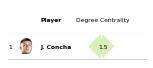

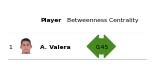

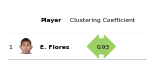

In [343]:
def beautiful_table_nwk(df, metric):
    
    overall = df 
    df = df.sort_values(by=f'{metric}', ascending=False)
    
    df = df.head(1)
    # Reset the index (to avoid any existing index) and then add 1 to the index values
    
    # Read in the logos
    df['badge'] = df['name'].apply(
        lambda x: f"players_png/{x}.png"
    )
    
    #define color map
    cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
    )
    
    df = df[['badge', 'name', metric]]
    
    df.reset_index(drop=True, inplace=True)
    df.index += 1
    
    # df = df[['badge', 'name', 'Total Passes', 'Successful Passes', 'Succ (%)']]
    
    col_defs = (
        
        [
            ColumnDefinition(
                name='name',
                title='Player',
                textprops={"ha": "left", "weight": "bold", 'color':'black'},
                width=0.5,
                
            ),
            
            ColumnDefinition(
                name='index',
                title="",
                textprops={"ha": "left", 'color':'black'},
                width=0.1,
            ),

            
            ColumnDefinition(
                name=f"{metric}",
                width=2,
                textprops={
                    "ha":"center",
                    "bbox": {"boxstyle": "darrow", "pad": 0.85},
                    'color':'black',
                },
                cmap=normed_cmap(overall[f"{metric}"], cmap=matplotlib.cm.PiYG, num_stds=3.5),
            ),
            
            ColumnDefinition(
                name="badge",
                title="",
                textprops={"ha": "center", "va": "center"}, #, 'color': bg_color},
                width=0.6,
                plot_fn=image,
            )
        ]
        
        
    )
    
    # Graph
    plt.rcParams["font.family"] = ["DejaVu Sans"]
    plt.rcParams["savefig.bbox"] = "tight"
    
    fig, ax = plt.subplots(figsize=(2.5, 1))
    
    # **Set Background Color**
    #bg_color = "red"  # Change this to any color you want
    #fig.patch.set_facecolor(bg_color)
    #ax.set_facecolor(bg_color)
    
    table = Table(
        df,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        ax=ax,
        textprops={"fontsize": 6},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 0.1, "linestyle": "-"},
        column_border_kw={"linewidth": 0.4, "linestyle": "-"},
    )#.autoset_fontcolors(colnames=["xG", "xGA","xPTS", "xG per Game", "xGA per Game"])
    fig.savefig(f"table_nwx_{metric}.png", facecolor=ax.get_facecolor(), dpi=200)
    
    return df

beautiful_table_nwk(pass_metrics, 'Degree Centrality')
beautiful_table_nwk(pass_metrics, 'Betweenness Centrality')
beautiful_table_nwk(pass_metrics, 'Clustering Coefficient')

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from highlight_text import fig_text
from PIL import Image
import urllib
from mplsoccer import Radar, FontManager, grid
import numpy as np
import matplotlib.patheffects as path_effects
from highlight_text import ax_text, fig_text
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
import requests
import os
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from PIL import Image
import pandas as pd
import urllib
from reportlab.lib.utils import ImageReader
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics

In [352]:
def hex_to_rgb(hex):
    hex = hex.lstrip('#')  # Remove leading '#'
    r = int(hex[0:2], 16) / 255.0
    g = int(hex[2:4], 16) / 255.0
    b = int(hex[4:6], 16) / 255.0
    return r, g, b

# Function to extract the Top 3 for each category
def get_top_3(df, column):
    return df.nlargest(3, column)[["name", column]]

# Extract Top 3 players for each metric
top_total_passes = get_top_3(merged_passes, "Total Passes")
# top_successful_passes = get_top_3(merged_passes, "Successful Passes")
top_success_rate = get_top_3(merged_passes, "Succ (%)")
# top_xT = get_top_3(xT_gb, 'Progressive xT')
top_xT = xT_gb[['name', 'Progressive xT']].head(3)

def get_top_1(df, column):
    return df.nlargest(1, column)[["name", column]]

top_degree = get_top_1(pass_metrics, "Degree Centrality")
top_betweenness = get_top_1(pass_metrics, "Betweenness Centrality")
top_clustering = get_top_1(pass_metrics, "Clustering Coefficient")



def report_generation():
    width, height = 1300, 1200
    c = canvas.Canvas("report_sample.pdf", pagesize=(width, height))

    ''' BACKGROUND COLOR '''
    c.setFillColorRGB(*hex_to_rgb('#00000')) 
    c.rect(0, 0, width, height, fill=True)
    
    ''' PASS NETWORK GRAPH '''
    c.drawImage(f'pass_network.png', 20, 450)#, width=270, height=220)
    
    #c.drawImage(f'table.png' , 50, 50, width=450, height=250)
    c.drawImage(f'table_passes.png' , 20, 30) #, width=450, height=250)
    c.drawImage(f'table_xT.png' , 825, 30) #, width=450, height=250)
    
    c.drawImage(f'table_nwx_Betweenness Centrality.png' , 825, 440)
    c.drawImage(f'table_nwx_Clustering Coefficient.png' , 825, 620)
    c.drawImage(f'table_nwx_Degree Centrality.png' , 825, 800)
    
    
    
    
    



    # Save the report
    c.save()

# Generate report
report_generation()

In [356]:
from reportlab.pdfgen import canvas
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics

def report_generation():
    width, height = 1300, 1200
    c = canvas.Canvas("report_sample.pdf", pagesize=(width, height))

    # **REGISTER DEJAVU SANS FONT**
    pdfmetrics.registerFont(TTFont('DejaVuSans', 'DejaVuSans.ttf'))
    
    # Set font
    c.setFont("DejaVuSans", 36)  # Title font size

    ''' BACKGROUND COLOR '''
    c.setFillColorRGB(*hex_to_rgb('#000000'))  # Ensure correct hex color
    c.rect(0, 0, width, height, fill=True)
    
    ''' ADD TITLE '''
    c.setFillColorRGB(1, 1, 1)  # White color for title text
    c.drawCentredString(width / 2, height - 100, "Pass Network Analysis Report")

    ''' PASS NETWORK GRAPH '''
    c.drawImage('pass_network.png', 20, 450)  # Adjust positioning as needed

    # Add tables
    c.drawImage('table_passes.png', 20, 30)
    c.drawImage('table_xT.png', 825, 30)
    c.drawImage('table_nwx_Betweenness Centrality.png', 825, 440)
    c.drawImage('table_nwx_Clustering Coefficient.png', 825, 620)
    c.drawImage('table_nwx_Degree Centrality.png', 825, 800)

    # Save the report
    c.save()

# Generate report
report_generation()


In [ ]:
def report_generation():
    
    # Prefixing the Width and Height of the Report
    width, height = 780, 900
    
    # Creating the canvas in the appropiate directory
    c = canvas.Canvas(f'report_sample.pdf', pagesize=(width, height))
    ''' BACKGROUND COLOR '''
    c.setFillColorRGB(0.10588235, 0.11764706, 0.13333333)  
    c.rect(0, 0, 780, 900, fill=True)
    
    # Save and close the PDF file
    c.save()